In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from torchsummary import summary
import tensorflow as tf
import datasets
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from time import time
import gc

# Offense module

In [2]:
#roBERTa model
off_MOD = f"cardiffnlp/twitter-roberta-base-offensive"

#Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(off_MOD)
off_class_mod = AutoModelForSequenceClassification.from_pretrained(off_MOD)

In [3]:
def Compute_Offense(tokenizer,off_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []
  for batch in batches:
      encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
        
      # Compute the outputs of the module as a numpy array.
      emb_1 = off_mod(**encoded_inputs)[0]
      scores_1 = []
      for i in range(emb_1.shape[0]):
            scores_1.append(softmax(emb_1[i].detach().numpy()))
      scores_1 = np.array(scores_1)
      batch_out_1.append(scores_1)
    
      encoded_inputs = None
      emb_1 = None
      gc.collect() 
    
  outs_off = np.concatenate(batch_out_1,axis=0)  

  return outs_off

## Loading the texts and labels of the train data

In [4]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [5]:
def truncate(texts,max_length):
    for i in range(len(texts)):
      if len(texts[i]) > max_length:
        texts[i] = texts[i][:max_length]
    return texts

In [6]:
max_length = 150

In [7]:
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_train = get_texts(df_train)
frenk_train = truncate(frenk_train,max_length)
frenk_label_train = df_train["label"].to_numpy()

In [8]:
df_train = pd.read_csv('data/try_train_8404.tsv',sep='\t')
try_train = get_texts(df_train)
try_train = truncate(try_train,max_length)
try_label_train = df_train['hate'].to_numpy()

## Computing the offensivity (If it's already saved you can skip this step)

In [11]:
batch_size = 32

In [12]:
t = time()
outs_off = Compute_Offense(tokenizer,off_class_mod,frenk_train,batch_size)
print("Elapsed time:",time()-t)

class_off = []
for i in range(len(frenk_train)):
    class_off.append(outs_off[i].argmax()) 

np.save('outs/frenk/class_off_train_outs.npy',class_off)

Elapsed time: 474.4314465522766


In [13]:
t = time()
outs_off = Compute_Offense(tokenizer,off_class_mod,try_train,batch_size)
print("Elapsed time:",time()-t)

class_off = []
for i in range(len(try_train)):
    class_off.append(outs_off[i].argmax())   
    
np.save('outs/try/class_off_train_outs.npy',class_off)

Elapsed time: 464.08770513534546


# Training inputs

## Embeddings and binary offense

In [9]:
frenk_sent_train = np.load('outs/frenk/sent_train_outs.npy')
frenk_c_off_train = np.load('outs/frenk/class_off_train_outs.npy')
frenk_gen_train = np.load('outs/frenk/gen_train_outs.npy')

In [10]:
try_sent_train = np.load('outs/try/sent_train_outs.npy')
try_c_off_train = np.load('outs/try/class_off_train_outs.npy')
try_gen_train = np.load('outs/try/gen_train_outs.npy')

In [11]:
sent_train = np.concatenate([frenk_sent_train,try_sent_train],axis=0)
c_off_train = np.concatenate([frenk_c_off_train,try_c_off_train],axis=0)
gen_train = np.concatenate([frenk_gen_train,try_gen_train],axis=0)

In [12]:
c_off_train = c_off_train.reshape(len(c_off_train),1)
conc_train = np.concatenate([sent_train,c_off_train,gen_train],axis=1)

## Labels

In [13]:
label_train = np.concatenate([frenk_label_train,try_label_train])

In [14]:
c_weights = compute_class_weight('balanced', classes=np.unique(label_train), y=label_train)
c_weights = {0:c_weights[0], 1:c_weights[1]}

# Factual inputs

In [15]:
sent_fact_outs = np.load('outs/counterfactuals/sent_fact_outs.npy')
factual_off = np.load('outs/counterfactuals/factual_off.npy')
gen_fact_outs = np.load('outs/counterfactuals/gen_fact_outs.npy')

In [16]:
factual_off = factual_off.reshape(len(factual_off),1)
conc_fact = np.concatenate([sent_fact_outs,factual_off,gen_fact_outs],axis=1)

# Counterfactual inputs

In [17]:
# Offense intervention
cf_off = []
for i in range(len(factual_off)):
    if factual_off[i][0] == 0:
        cf_off.append([1])
    else:
        cf_off.append([0])
cf_off = np.array(cf_off)

In [18]:
conc_cf = np.concatenate([sent_fact_outs,cf_off,gen_fact_outs],axis=1)

# PEACE model

In [19]:
n_avg = 20

In [20]:
f_hate = []
cf_hate = []
for i in range(n_avg):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_train, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    f_hate.append(np.squeeze(hate_model.predict(conc_fact)))
    cf_hate.append(np.squeeze(hate_model.predict(conc_cf)))
f_hate = np.mean(f_hate,axis=0)
cf_hate = np.mean(cf_hate,axis=0)

Epoch 1/10
526/526 [==============================] - 2s 2ms/step - loss: 0.5504 - accuracy: 0.7025
Epoch 2/10
526/526 [==============================] - 1s 2ms/step - loss: 0.5227 - accuracy: 0.7194
Epoch 3/10
526/526 [==============================] - 1s 2ms/step - loss: 0.5064 - accuracy: 0.7323
Epoch 4/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4960 - accuracy: 0.7363
Epoch 5/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4845 - accuracy: 0.7371
Epoch 6/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4705 - accuracy: 0.7476
Epoch 7/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4596 - accuracy: 0.7527
Epoch 8/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4478 - accuracy: 0.7603
Epoch 9/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4328 - accuracy: 0.7667
Epoch 10/10
98/98 [==============================] - 0s 1ms/step
Epoch 1/10
526/526 [===============

# Computing the ITE

In [21]:
ITE_peace = []
for i in range(len(f_hate)):
    if factual_off[i][0]:
        ITE_peace.append(f_hate[i] - cf_hate[i])
    else:
        ITE_peace.append(cf_hate[i] - f_hate[i])

# ATE (as the average ITE)

In [22]:
print("Average ITE",np.mean(ITE_peace))

Average ITE 0.04908868


<Axes: >

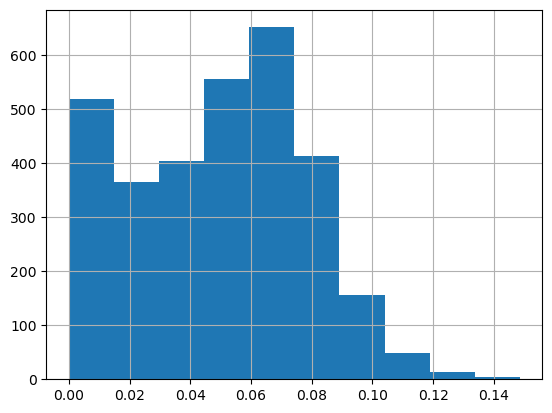

In [23]:
pd.Series(ITE_peace).hist()

In [24]:
print(np.max(ITE_peace))
print(np.min(ITE_peace))

0.14852878
2.525455e-09
